# Data Analysis with Spark.SQL: Visualizing
* **Author**: Jose Rodriguez (@Cyb3rPandah)
* **Project**: Infosec Jupyter Book
* **Public Organization**: [Open Threat Research](https://github.com/OTRF)
* **License**: [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/)
* **Reference**: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html

## Creating SQL view from Mordor APT29 dataset

### Create Spark session

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Spark_Data_Analysis") \
    .config("spark.sql.caseSensitive","True") \
    .getOrCreate()

### Expose the dataframe as a SQL view

In [2]:
apt29Json = 'datasets/apt29_evals_day1_manual_2020-05-01225525.json'

apt29Df = spark.read.json(apt29Json)

apt29Df.createOrReplaceTempView('apt29')

## Visualizing data

### Get most frecuent Destination IPs in Network Connection events (More than 10 connections)

* Create dataframe

In [3]:
networkConnections = spark.sql(
'''
SELECT DestinationIp, count(*) as Frequency
FROM apt29
WHERE lower(Channel) LIKE '%sysmon%'
    AND EventID = 3
GROUP BY DestinationIp
HAVING Frequency > 10
ORDER BY Frequency DESC
''')

print('This dataframe has {} records!!'.format(networkConnections.count()))
networkConnections.show()

This dataframe has 8 records!!
+--------------------+---------+
|       DestinationIp|Frequency|
+--------------------+---------+
|         192.168.0.4|      356|
|            10.0.0.4|      323|
|fe80:0:0:0:e40c:9...|      116|
|     0:0:0:0:0:0:0:1|      111|
|            10.0.1.4|       75|
|            10.0.1.6|       62|
|         172.18.39.2|       30|
|            10.0.1.5|       21|
+--------------------+---------+



* Create Vertical bar chart

In [4]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
from math import pi

In [5]:
output_notebook()

Loading BokehJS ...

In [6]:
# Source of Data
source = ColumnDataSource(networkConnections.toPandas()) 

# List of values for X axis
destinationIps = source.data['DestinationIp'].tolist()

# Figure object
p = figure(x_range = destinationIps,
           title="Frequency of Network Connections by Destination IPs")

# Vertical Chart
p.vbar(x = 'DestinationIp', top = 'Frequency', source = source, width = 0.7)

# Title Format
p.title.text_font = "arial"
p.title.text_font_size = "20px"
p.title.align = "center"

# X-axis format
p.xaxis.major_label_orientation = pi/2

# Data labels
labels = LabelSet(x = 'DestinationIp', y = 'Frequency', text = 'Frequency', level = 'glyph',
        x_offset = -10, y_offset = 0, source = source, text_font = 'arial', text_font_size = '15px')
p.add_layout(labels)

# Figure presentation
show(p)

### Represent variability of Command Line Length in Process creation events by User using a Box Plot

* Create dataframe

In [7]:
commandLineLength = spark.sql(
'''
SELECT User, length(CommandLine) as CommandLineLength
FROM apt29
WHERE lower(Channel) LIKE '%sysmon%'
    AND EventID = 1
    AND length(CommandLine) < 300
''')

print('This dataframe has {} records!!'.format(commandLineLength.count()))
commandLineLength.show(n = 5)

This dataframe has 439 records!!
+-------------------+-----------------+
|               User|CommandLineLength|
+-------------------+-----------------+
|    DMEVALS\pbeesly|               43|
|    DMEVALS\pbeesly|               99|
|    DMEVALS\pbeesly|               29|
|    DMEVALS\pbeesly|               10|
|NT AUTHORITY\SYSTEM|               66|
+-------------------+-----------------+
only showing top 5 rows



* Create a Box Plot chart

In [8]:
import seaborn as sns
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(15,7)})

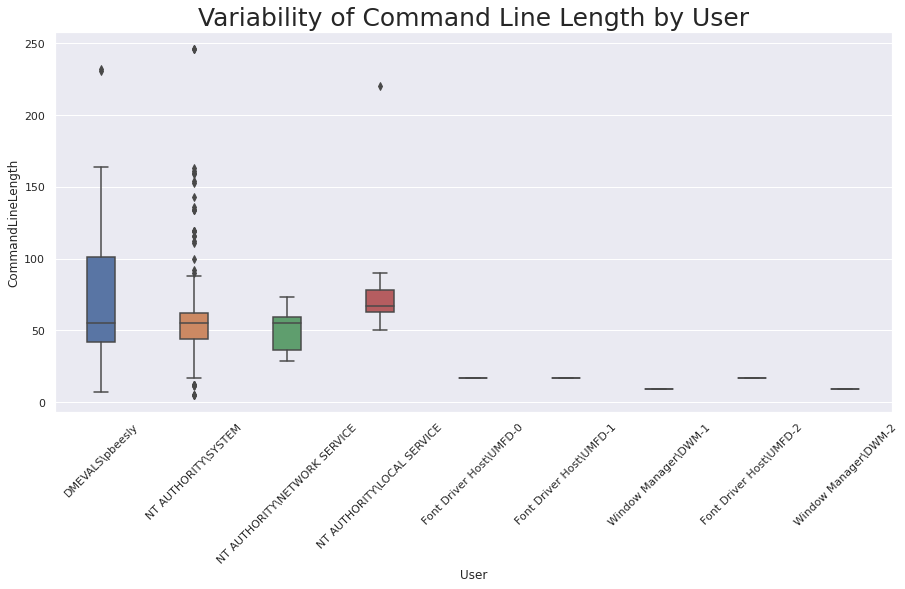

In [9]:
# Source of Data
source = commandLineLength.toPandas()

# seaborn object
boxPlotChart = sns.boxplot(x = 'User', y = 'CommandLineLength', data = source, orient = 'v',width = 0.3)

# Title format
boxPlotChart.set_title("Variability of Command Line Length by User", fontsize = 25)

# X-axis format
boxPlotChart.set_xticklabels(boxPlotChart.get_xticklabels(), rotation=45);

## Thank you! I hope you enjoyed it!